In [1]:
# Import required libraries
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds
import pathlib

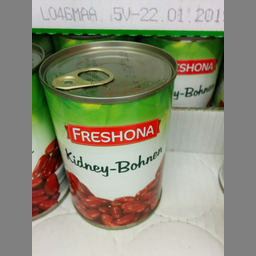

In [2]:
# Visualise data
data_dir = pathlib.Path('drive/MyDrive/image').with_suffix('')
roses = list(data_dir.glob('BEANS/*'))
PIL.Image.open(str(roses[0]))

In [5]:
# Create training set
batch_size = 32
img_height = 180
img_width = 180

train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.1,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

train_ds

Found 1128 files belonging to 5 classes.
Using 1016 files for training.


<_BatchDataset element_spec=(TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [6]:
# Create validation set
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.1,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)



Found 1128 files belonging to 5 classes.
Using 112 files for validation.


In [7]:
# Show classnames
class_names = train_ds.class_names
print(class_names)

['BEANS', 'CAKE', 'CANDY', 'CEREAL', 'CHIPS']


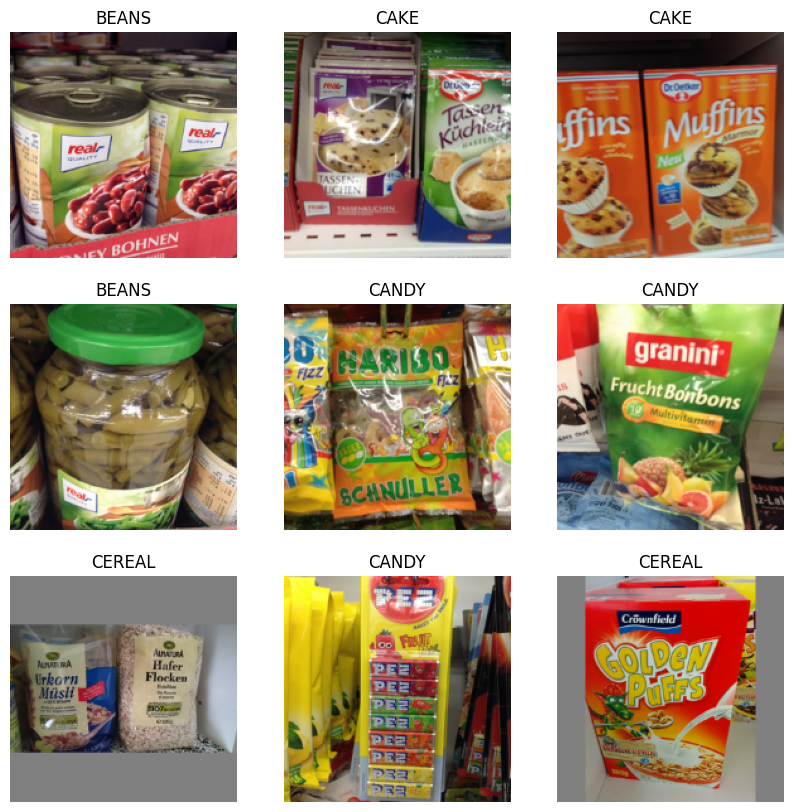

In [8]:
# Visualise data with labels
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [9]:
def data_augmenter():
    '''
    Create a Sequential model composed of 2 layers
    Returns:
        tf.keras.Sequential
    '''

    data_augmentation = tf.keras.Sequential()
    data_augmentation.add(tf.keras.layers.RandomFlip("horizontal"))
    data_augmentation.add(tf.keras.layers.RandomRotation(0.2))


    return data_augmentation

In [16]:
def grocery_model(image_shape=(180, 180), data_augmentation=None):
    '''
    Create a model with an Inception V3 base model trained on imagenet.
    Add data augmentation layer
    Add Rescaling layer to normalise data
    Add GlobalAveragePooling2D to sum up the channel information
    Add Dropout layer to prevent overfitting
    Add Dense layer with 5 units and softmax activation for classification

    Returns:
        model

    '''
    input_shape = image_shape + (3,)

    if data_augmentation is None:
        data_augmentation = data_augmenter()

    base_model = tf.keras.applications.InceptionV3(
        input_shape=input_shape,
        include_top=False,
        weights='imagenet'
    )
    base_model.trainable = False

    inputs = tf.keras.Input(shape=input_shape)
    x = data_augmentation(inputs)
    x = tf.keras.layers.Rescaling(1./255)(x)
    x = base_model(x)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    outputs = tf.keras.layers.Dense(
        5,
        kernel_regularizer=tf.keras.regularizers.l2(0.01),
        activation = 'softmax'
    )(x)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model

model = grocery_model()

In [11]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 180, 180, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 inception_v3 (Functional)   (None, 4, 4, 2048)        21802784  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                             

In [17]:
#Unfreeze layers after a specific layer to allow the base model to fine tune itself to our data.

base_model = model.layers[3]
base_model.trainable = True
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 280


# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

# Define a SparseCategoricalCrossentropy loss function. Use from_logits=True
loss_function= tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
# Define an Adam optimizer with a learning rate of 0.1 * base_learning_rate
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
# Use accuracy as evaluation metric
metrics=['accuracy']


checkpoint_path = "drive/MyDrive/training/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

model.compile(loss=loss_function,
              optimizer = optimizer,
              metrics=metrics)

Number of layers in the base model:  311


In [ ]:
# Fit the model for 50 epochs
model.fit(
  train_ds,
  validation_data=val_ds,
  callbacks=[cp_callback],
  epochs=50
)

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/backend.py:5612: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


32/32 [==============================] - ETA: 0s - loss: 1.0701 - accuracy: 0.6752
Epoch 1: saving model to drive/MyDrive/training/cp.ckpt
32/32 [==============================] - 121s 4s/step - loss: 1.0701 - accuracy: 0.6752 - val_loss: 1.9957 - val_accuracy: 0.7232
Epoch 2/50
32/32 [==============================] - ETA: 0s - loss: 0.5150 - accuracy: 0.8553
Epoch 2: saving model to drive/MyDrive/training/cp.ckpt
32/32 [==============================] - 69s 2s/step - loss: 0.5150 - accuracy: 0.8553 - val_loss: 0.7369 - val_accuracy: 0.8393
Epoch 3/50
32/32 [==============================] - ETA: 0s - loss: 0.3725 - accuracy: 0.9016
Epoch 3: saving model to drive/MyDrive/training/cp.ckpt
32/32 [==============================] - 76s 2s/step - loss: 0.3725 - accuracy: 0.9016 - val_loss: 0.6472 - val_accuracy: 0.8393
Epoch 4/50
32/32 [==============================] - ETA: 0s - loss: 0.2773 - accuracy: 0.9311
Epoch 4: saving model to drive/MyDrive/training/cp.ckpt
32/32 [================

4/4 [==============================] - 9s 2s/step


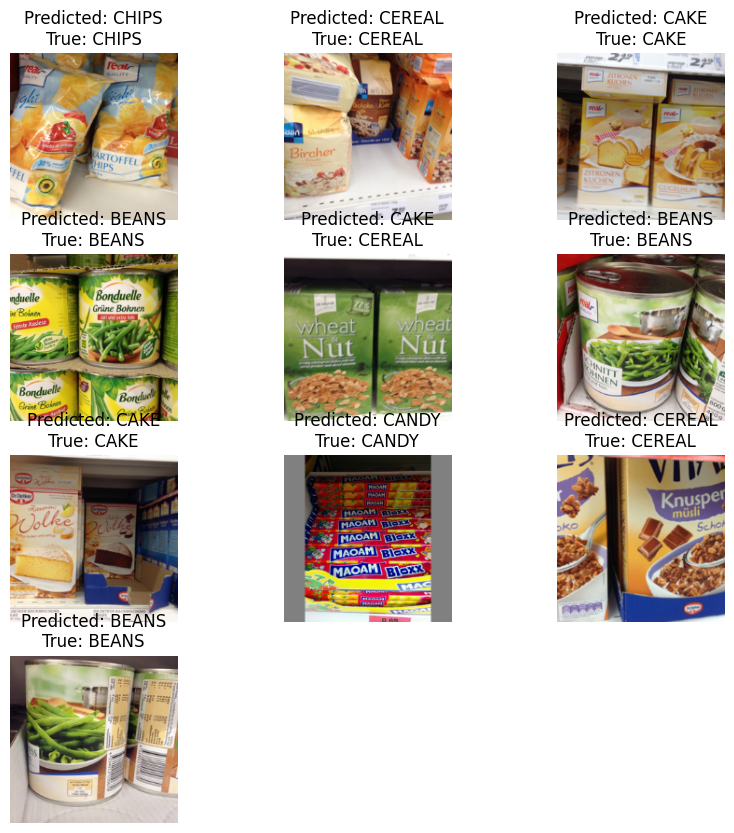

In [18]:


# Load the trained model
model.load_weights('drive/MyDrive/training/cp.ckpt')

# Select 10 images from the validation set
num_images = 10
val_images = []
val_labels = []

for images, labels in val_ds.take(num_images):
    val_images.append(images)
    val_labels.append(labels)

val_images = np.concatenate(val_images, axis=0)
val_labels = np.concatenate(val_labels, axis=0)

# Make predictions on the validation images
predictions = model.predict(val_images)

# Display the images along with the predicted labels
plt.figure(figsize=(10, 10))
for i in range(num_images):
    ax = plt.subplot(4, 3, i + 1)
    plt.imshow(val_images[i].astype("uint8"))
    predicted_label = class_names[np.argmax(predictions[i])]
    true_label = class_names[val_labels[i]]
    plt.title(f"Predicted: {predicted_label}\nTrue: {true_label}")
    plt.axis("off")

plt.show()


In [19]:
#Evaluate model
y = model.evaluate(val_ds)

print('Validation Accuracy:', max(y))


/usr/local/lib/python3.10/dist-packages/keras/backend.py:5612: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


4/4 [==============================] - 10s 2s/step - loss: 0.3053 - accuracy: 0.9196
Validation Accuracy: 0.9196428656578064
